In [1]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import cv2
from matplotlib import image

In [2]:
def make_W(img_path):
    # 转为灰度图 并且边缘检测
    img = cv2.imread(img_path)
    imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    imgCanny = cv2.Canny(imgGray,150,200)



    h,w=imgCanny.shape
    # 计算出对角线长度
    d=np.sqrt(w**2+h**2)
    print(f"w:{w} ,h:{h} ,d:{d}")
    #量化范围
    theta=np.linspace(0,np.pi,180)
    rou=np.linspace(-d,d,200)

    # 初始化W矩阵
    # 行为theta 列为rho
    W=np.zeros((180,200),dtype=np.int32)
    # 获取edge的图像
    img_edge_data=np.array(imgCanny)
    print(img_edge_data.shape)
    for i in range(0,h):
        for j in range(0,w):
            # 第i行 第j列
            if img_edge_data[i][j]==255:
    
                # 对于每一个theta_求出对应的rou_
                theta_=np.linspace(0,np.pi,180)
                # 此处使用的是相对于图片中心的相对坐标
                rou_=(i-h//2)*np.sin(theta)+(j-w//2)*np.cos(theta)
        
                # 求出theta rou在W中的坐标
                theta_index=np.arange(0,len(theta))
                
                rou_index=np.zeros_like(rou_,dtype=np.int16)
                for k in range(len(rou_)):
                    # 将rou量化到一定的范围中
                    rou_index[k]=np.argmin(np.abs(rou_[k]-rou))
                # 在对应点累加
                W[theta_index,rou_index]+=1
    
    return W,imgCanny,(w,h,d)






In [3]:
def compute_rho_theta_of_lines(W,threshold,img_info_tuple):
    w=img_info_tuple[0]
    h=img_info_tuple[1]
    d=img_info_tuple[2]
    index_=np.where(W>threshold)
    print(f"num_lines:{len(index_[0])}")
    rou_res=[]
    theta_res=[]
    for i in range(len(index_[0])):
        theta_res.append(np.pi/180*index_[0][i])
        rou_res.append(-d+2*d/200*index_[1][i])


    return rou_res,theta_res
def compute_points_in_line(theta_res,rou_res,w,h):
    theta_res=np.array(theta_res)
    rou_res=np.array(rou_res)

    x=w//2+rou_res*np.cos(theta_res)
    y=h//2+rou_res*np.sin(theta_res)
    x1=x-np.sin(theta_res)*500
    x2=x+np.sin(theta_res)*500
    y1=y+np.cos(theta_res)*500
    y2=y-np.cos(theta_res)*500
    # x=h//2+rou_res*np.sin(theta_res)
    # y=w//2+rou_res*np.cos(theta_res)
    # x1=x+-np.cos(theta_res)*500
    # x2=x-np.cos(theta_res)*500
    # y1=y-np.sin(theta_res)*500
    # y2=y+np.sin(theta_res)*500
    line_x=np.column_stack((x1,x2))
    line_y=np.column_stack((y1,y2))
    line_x.astype(np.int16)
    line_y.astype(np.int16)
    return line_x,line_y


In [4]:

def show_img_done(img_path,line_x,line_y):
    data = image.imread(img_path)
    for i in range(len(line_x)):
        plt.plot(line_x[i],line_y[i],color='b', linestyle='-', linewidth=0.1)
    plt.imshow(data)
    plt.show()

w:800 ,h:600 ,d:1000.0
(600, 800)
num_lines:80


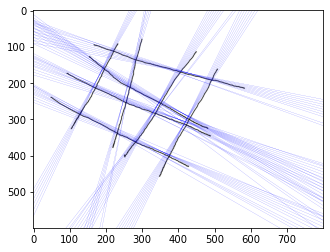

In [5]:
img_path="/home/starfish/桌面/DIP/Learn-OpenCV-in-3-hours-master/Resources/lines3.png"
threshold=400
W,imgCanny,img_info_tuple=make_W(img_path)
rou_res,theta_res=compute_rho_theta_of_lines(W,threshold,img_info_tuple)
line_x,line_y=compute_points_in_line(theta_res,rou_res,img_info_tuple[0],img_info_tuple[1])
show_img_done(img_path,line_x,line_y)


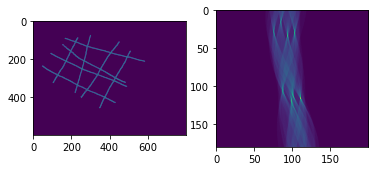

In [6]:
plt.subplot(1,2,1)
plt.imshow(imgCanny)
plt.subplot(1,2,2)
plt.imshow(W)


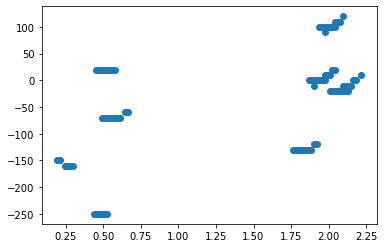

In [7]:
plt.scatter(theta_res,rou_res)

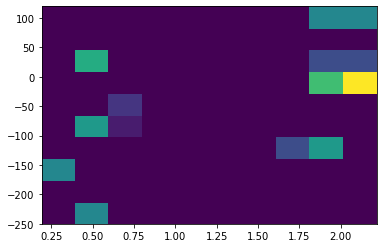

In [8]:
plt.hist2d(theta_res,rou_res)
plt.show()

In [9]:
rou_res_=np.array(rou_res)/100

In [10]:
data_to_be_cluster=np.stack((theta_res,rou_res_),axis=1)
data_to_be_cluster.shape

(80, 2)

In [35]:
# 分类的数目
N = 8
# 迭代数目
num_iter = 50

num_data = data_to_be_cluster.shape[0]

# 随机抽选作为初始center
index = np.random.choice(num_data, N)
centers = data_to_be_cluster[index]

assignment = np.zeros(num_data, dtype=np.int16) - 1

for i in range(num_iter):
    for j in range(num_data):
        errors=np.sum((data_to_be_cluster[j] - centers) ** 2,axis=1)
        assignment[j] = np.argmin(errors)

    for k in range(len(centers)):
        # 获取属于该分类的点
        filt = assignment == k
        if len(data_to_be_cluster[filt])!=0:
            new_center=np.mean(data_to_be_cluster[filt], axis=0)
            centers[k] = new_center

In [36]:
print(assignment)


[5 5 5 5 5 5 5 5 6 5 6 5 6 6 5 6 6 5 6 6 6 6 6 6 6 6 6 6 6 6 3 3 3 3 3 3 3
 7 3 7 3 7 7 3 7 7 1 7 1 7 4 1 1 4 1 2 4 1 2 4 1 2 4 1 1 2 1 2 1 2 2 1 2 2
 2 2 2 4 4 4]


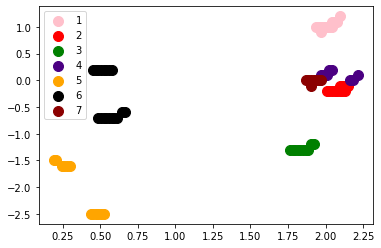

In [37]:


scatter_x = data_to_be_cluster.T[0]
scatter_y = data_to_be_cluster.T[1]
group = assignment
cdict = {0:'blue', 1:'pink', 2: 'red', 3: 'green',4: 'indigo', 5: 'orange', 6: 'black',7: 'darkred'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)
ax.legend()
plt.show()

In [38]:
centers

array([[ 1.96175008,  0.49333333],
       [ 2.01440085,  1.03333333],
       [ 2.08566846, -0.16666667],
       [ 1.84132236, -1.28      ],
       [ 2.07476015,  0.1       ],
       [ 0.36361026, -2.03333333],
       [ 0.5459002 , -0.28888889],
       [ 1.91768052, -0.0125    ]])

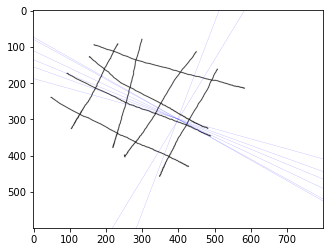

In [39]:
line_x,line_y=compute_points_in_line(centers.T[0],centers.T[1],img_info_tuple[0],img_info_tuple[1])
show_img_done(img_path,line_x,line_y)